In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from PIL import Image
from torch import nn, Tensor
import torch.nn.functional as F
import math
from typing import Tuple
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import pandas as pd
import logging

import vit
from helper import *

c:\programdata\miniconda3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
USE_CUDA = True

In [3]:
if torch.cuda.is_available() and USE_CUDA == True:
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [4]:
train = geneDataset("train")
test = geneDataset("test")

In [5]:
trainset = torch.utils.data.DataLoader(train, batch_size=40, shuffle=True)
testset = torch.utils.data.DataLoader(test, batch_size=40, shuffle=True)

In [6]:
import gc

try:
    del net
    del X
    del y
    
except:
    print("variable not yet declared")

gc.collect()

variable not yet declared


0

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x.type(torch.FloatTensor)


In [8]:
net = vit.VisionTransformer()
net.to(device)

VisionTransformer(
  (embedding_layer): EmbeddingStem(
    (projection): Sequential(
      (0): Conv2d(1, 96, kernel_size=(16, 16), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(96, 96, kernel_size=(6, 6), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(96, 96, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
      (7): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): Conv2d(96, 192, kernel_size=(2, 2), stride=(2, 2))
    )
  )
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            

In [9]:
total_params = sum(p.numel() for p in net.parameters())
print(total_params)

6534721


In [10]:
loss_function = torch.nn.L1Loss()

In [11]:
def getTestLoss():
    loss = 0
    
    for data in testset:
        X, y = data
        X = X.to(device)

        output = net(X)
        loss += loss_function(output, y)
    
    return(loss)

In [12]:
pos = 0
neg = 0

def getAccuracy(net):
    wrong = 0
    right = 0
    total = 0

    with torch.no_grad():
        for data in testset:
            X, y = data

            X = X.to(device)
            y = y.to(device)

            output = net(X)

            for i in range(len(output)):
                if y[i][0] == round(float(output[i][0])):
                    right += 1
                else:
                    wrong += 1

                total += 1

    return (right / total)

In [13]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.0005)

In [14]:
trainloss = []
testloss = []

In [15]:
EPOCHS = 15
count = 0

lowestLoss = 0
lowestNet = 0

In [16]:
for epoch in range(EPOCHS):    
    for data in trainset:
        X, y = data
        X = X.to(device)

        net.zero_grad()
        output = net(X)
        loss = loss_function(output, y)
        loss.backward()
        optimizer.step()
        
    count += 1 

    print(f"{round((count * 100 / EPOCHS), 2)}% Completed")

    trainloss.append(float(loss))

    testLoss = getAccuracy(net)
    testloss.append(testLoss)

    if testLoss > lowestLoss:
        lowestLoss = testLoss
        lowestNet = epoch

    torch.save(net, f"nets/net{epoch}.pt")


print("100% Completed")

6.67% Completed
13.33% Completed
20.0% Completed
26.67% Completed
33.33% Completed
40.0% Completed
46.67% Completed
53.33% Completed
60.0% Completed
66.67% Completed
73.33% Completed
80.0% Completed
86.67% Completed
93.33% Completed
100.0% Completed
100% Completed


In [17]:
print(lowestNet)

12


In [18]:
# lowestNet = 99

In [36]:
# net = torch.load(f"nets/net{lowestNet}.pt")

In [37]:
pos = 0
neg = 0


wrong = 0
right = 0
total = 0

with torch.no_grad():
    for data in testset:
        X, y = data

        X = X.to(device)
        y = y.to(device)

        output = net(X)

        for i in range(len(output)):
            if y[i][0] == round(float(output[i][0])):
                right += 1
            else:
                wrong += 1

            total += 1

print(right / total)

0.814595660749507


In [38]:
RES = 1000

In [39]:
falsePos = [0] * RES
truePos = [0] * RES
falseNeg = [0] * RES
trueNeg = [0] * RES

In [40]:
count = 0

with torch.no_grad():
    for data in testset:
        X, y = data
        
        X = X.to(device)
        y = y.to(device)

        output = net(X)
        
        for i in range(RES):
            loss = wrongAns(output, y, 2 * i / (RES - 1) - 0.5)
            truePos[i] += loss[0]
            falsePos[i] += loss[1]
            trueNeg[i] += loss[2]
            falseNeg[i] += loss[3]
        
        count += 1
        
        if count % 1 == 0:
            print(f"{round(count * 100 / len(testset), 2)}% Completed")

7.69% Completed
15.38% Completed
23.08% Completed
30.77% Completed
38.46% Completed
46.15% Completed
53.85% Completed
61.54% Completed
69.23% Completed
76.92% Completed
84.62% Completed
92.31% Completed
100.0% Completed


Accuracy: 0.8382642998027613
506


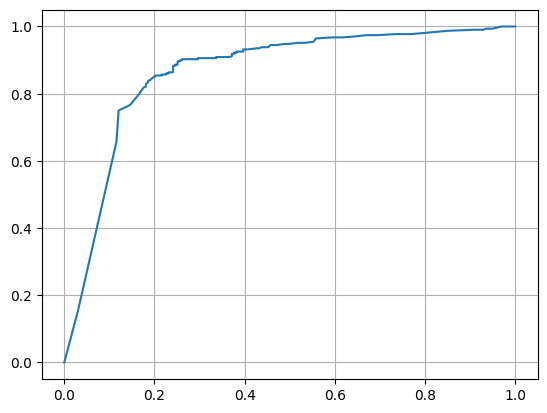

In [41]:
hAcu = 0

falsePosRate = []
truePosRate = []

for i in range(len(truePos)):
    falsePosRate.append(falsePos[i] / (falsePos[i] + trueNeg[i]))
    truePosRate.append(truePos[i] / (truePos[i] + falseNeg[i]))

for i in range(RES):
    if hAcu < truePos[i] + trueNeg[i]:
        hAcu = truePos[i] + trueNeg[i]
        lowestIndex = i

print(f"Accuracy: {(truePos[lowestIndex] + trueNeg[lowestIndex]) / (falsePos[0] + falseNeg[0] + truePos[0] + trueNeg[0])}")
print(lowestIndex)
    
plt.plot(falsePosRate, truePosRate)
plt.grid()

In [42]:
import sklearn.metrics

auc = sklearn.metrics.auc(falsePosRate, truePosRate)

print(auc)

0.8656513084905045


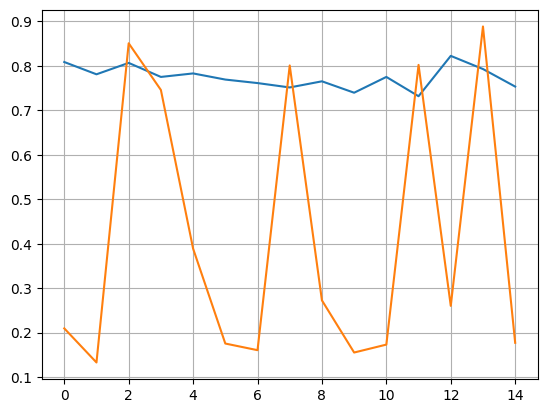

In [43]:
plt.plot(testloss)
plt.plot(trainloss)
plt.grid()

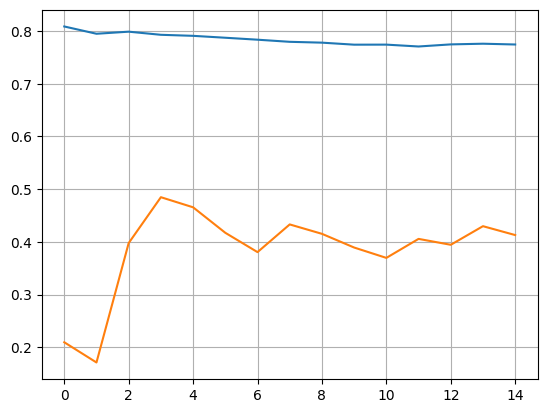

In [44]:
avgTrainLoss = getAvgLoss(trainloss)
avgTestLoss = getAvgLoss(testloss)

plt.plot(avgTestLoss)
plt.plot(avgTrainLoss)
plt.grid()

In [45]:
data = iter(testset)

tensor([0.], device='cuda:0')


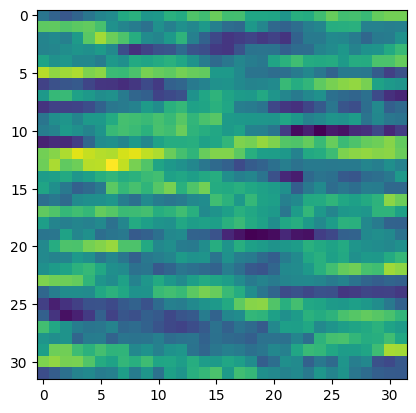

In [46]:
X, y = data.next()

X = X.to(device)
y = y.to(device)
        
output = net(X)

print(y[0])
plt.imshow(X[0].view((32, 32)).cpu())

In [47]:
i = 0

tensor([0.], device='cuda:0')
tensor([0.0547], grad_fn=<SelectBackward0>)


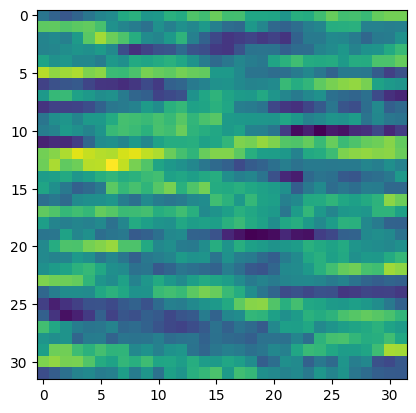

In [48]:
print(y[i])
print(output[i])
plt.imshow(X[i].view((32, 32)).cpu())

i += 1
i %= 20

In [49]:
print(y.view(-1))

tensor([0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1.,
        1., 1., 1., 0.], device='cuda:0')


In [50]:
print(output.view(-1))


tensor([0.0547, 1.0387, 1.0401, 0.0357, 1.0408, 0.8958, 0.0385, 1.0404, 0.5494,
        1.0403, 1.0401, 1.0377, 1.0408, 1.0395, 1.0399, 0.0667, 1.0164, 1.0168,
        1.0400, 1.0403, 1.0407, 0.0330, 1.0395, 1.0393, 0.0457, 1.0377, 0.5659,
        0.0240, 1.0404, 1.0381, 1.0343, 0.0254, 0.0258, 1.0400, 1.0214, 0.4829,
        1.0403, 1.0396, 1.0395, 0.0276], grad_fn=<ViewBackward0>)


In [51]:
print(X)

tensor([[[[0.8255, 0.7584, 0.7125,  ..., 1.1809, 1.2035, 1.2046],
          [1.1695, 1.1750, 1.1485,  ..., 0.8733, 0.8621, 0.8709],
          [0.8853, 0.9059, 0.8697,  ..., 0.8458, 0.8559, 0.9362],
          ...,
          [0.9874, 1.1963, 1.2007,  ..., 1.1126, 1.2809, 1.2728],
          [1.2219, 1.2479, 1.2117,  ..., 0.6892, 0.6630, 0.7197],
          [0.6793, 0.7370, 0.8112,  ..., 0.7430, 0.7287, 0.7251]]],


        [[[1.2180, 1.0762, 1.0388,  ..., 1.0560, 1.0127, 0.9957],
          [0.9863, 1.0139, 0.9537,  ..., 0.9322, 0.8277, 0.8404],
          [0.8728, 0.8860, 0.9475,  ..., 1.0069, 1.0364, 1.0597],
          ...,
          [0.8903, 0.8667, 0.9247,  ..., 1.3910, 1.2154, 1.2811],
          [1.2647, 1.2460, 1.2885,  ..., 1.3639, 1.2684, 1.3191],
          [1.3506, 1.3355, 1.4166,  ..., 1.2801, 1.3086, 1.3525]]],


        [[[1.3177, 1.3476, 1.3354,  ..., 1.2224, 1.1534, 1.1549],
          [1.2063, 1.1924, 1.2510,  ..., 1.2111, 1.2811, 1.2001],
          [1.2446, 1.1076, 1.1130,  ..

In [35]:
def wrongAns(output, expected, threshold):
    falseNeg = 0
    trueNeg = 0
    falsePos = 0
    truePos = 0
    total = 0
    
    for i in range(len(output)):
        if int(expected[i][0]) > 0.5:
            if float(output[i][0]) < threshold:
                falseNeg += 1
            
            else:
                truePos += 1
        else:
            if float(output[i][0]) >= threshold:
                falsePos += 1
                
            else:
                trueNeg += 1

        total += 1
    
    return(truePos, falsePos, trueNeg, falseNeg)